# Problem 1
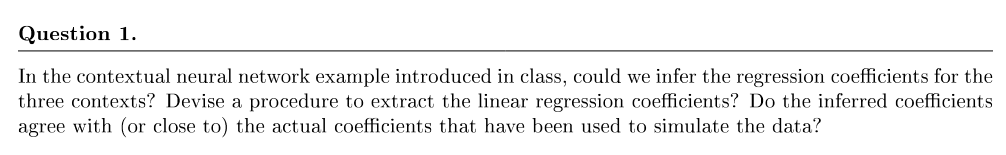

---

# 🧠 Contextual Neural Network — Full Workflow Explanation

This document walks through the complete process of building, training, and evaluating a contextual neural network that learns different linear relationships depending on context (in this case, age).

---

We simulate a synthetic dataset where:

- Each observation is drawn from one of three linear models, depending on age (context).
- Noise is added via a normal distribution:

$$
\varepsilon \sim \mathcal{N}(0, 0.5^2)
$$

### 📊 Context Breakdown

- **Context 1**: Age 20–30  
  $$
  y = 50 + 20x + \varepsilon
  $$

- **Context 2**: Age 31–40  
  $$
  y = 1 + 1x + \varepsilon
  $$

- **Context 3**: Age 41–50  
  $$
  y = -50 - 20x + \varepsilon
  $$

---

## 🧱 Step 2: Data Splitting

The dataset is randomly shuffled and split into:
- **Training set**: First 150 rows
- **Validation set**: Rows 150–299 (used for monitoring training)
- **Test set**: Remaining rows (unseen by the model)

Each input has two features:
- `x`: the main variable
- `age`: the context variable

---

## 🧠 Step 3: Define Contextual Neural Network Architecture

We construct a neural network that can **adapt its predictions based on contextual information** (in this case, age). The architecture is designed to learn different mappings between `x` and `y` for different contexts by modulating intermediate layers.

---

### 🔌 Model Components

- **🔹 Two Inputs**:
  - `main_input`: the primary feature \( x \)
  - `context_input`: the contextual variable (e.g., age)

- **🔄 Normalization Layers**:
  - Both `x` and `age` are normalized independently using `tf.keras.layers.Normalization()`.

- **🧬 Context Encoding**:
  - The context input is passed through **six parallel Dense layers**, each with:
    ```python
    Dense(1, activation="sigmoid")
    ```
  - These serve as **context encoders** that transform the age into soft signals.

- **🔗 Feature Fusion**:
  - Each context output is concatenated with the normalized `x` value:

    $$
    \text{fused}_i = \text{Concat}(\text{x}_\text{norm}, \text{context}_i)
    $$




- **⚙️ Nonlinear Transformation**:
  - Each fused pair is processed by a separate `Dense(1, activation="relu")` layer.
  - This allows the model to learn **context-specific transformations** of the input.

- **🧮 Final Output Layer**:
  - All 6 context-specific outputs are concatenated:
    $$
    \text{final} = \text{Concat}(h_1, h_2, ..., h_6)
    $$
  - The result is passed to a final `Dense(1)` layer to produce the prediction **ŷ**.


This architecture enables the model to:
- Learn **different regression behaviors** depending on the context.
- Maintain **shared structure** where appropriate, but **modulate predictions** via context-aware pathways.
- Serve as a **soft conditional model** — blending nonlinear regression with context gating.



---

## ⚙️ Step 4: Compile the Model

The model is compiled with:
- **Loss**: Mean Squared Error (`"mse"`)
- **Optimizer**: Adam (default learning rate)
- **Metric**: Root Mean Squared Error (`"RootMeanSquaredError"`)

---

## 📈 Step 5: Normalize & Train the Model

- The `Normalization` layers are **adapted using only the training set**.
- The model is trained for **30,000 epochs** with training + validation data to monitor learning progress.

> 🔁 30,000 epochs are used here because the data is synthetic and clean, allowing long training to fully capture the signal.

---

## 🧪 Step 6: Evaluate Performance

The model is evaluated using:
- Training set → to ensure it has captured the behavior of the data it was trained on.
- Test set → to assess generalization performance.

Outputs:
- **MSE** and **RMSE** on both datasets.

---

## 🔮 Step 7: Generate Predictions

We use `model.predict(...)` to generate:
- `y_pred_train`: Predictions on the training set
- `y_pred`: Predictions on the test set

These predictions will be used in further steps to:
- Compare with true values
- Extract context-specific coefficients
- Visualize model performance

---

## ✅ Summary

This pipeline demonstrates how to:
- Simulate data from multiple contexts
- Train a neural network that adapts its behavior based on context
- Evaluate whether the model has truly learned the relationships per context


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

# --- Step 1: Simulate Contextual Linear Data ---
np.random.seed(20201130)
x1 = np.random.random(450) * 2 - 1
age1 = np.random.randint(20, 31, 150)
age2 = np.random.randint(31, 41, 150)
age3 = np.random.randint(41, 51, 150)
age = np.concatenate((age1, age2, age3))
xmat = np.hstack((np.repeat(1, 450).reshape(-1, 1), x1.reshape(-1, 1), age.reshape(-1, 1)))

# Define true coefficients for each context
beta1vec = np.array([50, 20]).reshape(-1, 1)
beta2vec = np.array([1, 1]).reshape(-1, 1)
beta3vec = np.array([-50, -20]).reshape(-1, 1)

# Add Gaussian noise
epsvec = np.random.normal(0, 0.5, 450).reshape(-1, 1)

# Generate y using context-specific linear models
yvec1 = xmat[:150, :2] @ beta1vec + epsvec[:150]
yvec2 = xmat[150:300, :2] @ beta2vec + epsvec[150:300]
yvec3 = xmat[300:, :2] @ beta3vec + epsvec[300:]
yvec = np.vstack((yvec1, yvec2, yvec3))

# Combine into a dataset and shuffle
nnmixdf = np.hstack((yvec, xmat[:, 1:]))  # y, x, age
ivec = np.random.permutation(450)
nnmixdf = nnmixdf[ivec, :]

# --- Step 2: Data Splitting ---
X_train, y_train = nnmixdf[:150, 1:], nnmixdf[:150, 0]
X_valid, y_valid = nnmixdf[150:300, 1:], nnmixdf[150:300, 0]
X_test, y_test = nnmixdf[300:, 1:], nnmixdf[300:, 0]

# --- Step 3: Define Contextual Neural Network ---
tf.random.set_seed(202311)
input_main = tf.keras.layers.Input(shape=[1], name="main_input")
input_ctxt = tf.keras.layers.Input(shape=[1], name="context_input")
norm_layer_main = tf.keras.layers.Normalization()
norm_layer_ctxt = tf.keras.layers.Normalization()
norm_main = norm_layer_main(input_main)
norm_ctxt = norm_layer_ctxt(input_ctxt)

# Create multiple context-aware outputs
context_outputs = [
    tf.keras.layers.Dense(1, activation="sigmoid", name=f"output_ctxt{str(i+1).zfill(2)}")(norm_ctxt)
    for i in range(6)
]

# Fuse each context output with the main input
concat_layers = [tf.keras.layers.Concatenate(name=f"concat{str(i+1).zfill(2)}")([norm_main, context_outputs[i]]) for i in range(6)]
hidden_layers = [tf.keras.layers.Dense(1, activation="relu")(layer) for layer in concat_layers]

# Final aggregation and output
concat = tf.keras.layers.Concatenate()(hidden_layers)
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_main, input_ctxt], outputs=[output])
model.summary()

# --- Step 4: Compile Model ---
optimizer_adam = tf.keras.optimizers.Adam()
model.compile(loss="mse", optimizer=optimizer_adam, metrics=["RootMeanSquaredError"])

# --- Step 5: Normalize and Train ---
X_train_main, X_train_ctxt = X_train[:, 0].reshape(-1, 1), X_train[:, 1].reshape(-1, 1)
X_valid_main, X_valid_ctxt = X_valid[:, 0].reshape(-1, 1), X_valid[:, 1].reshape(-1, 1)
X_test_main, X_test_ctxt = X_test[:, 0].reshape(-1, 1), X_test[:, 1].reshape(-1, 1)

norm_layer_main.adapt(X_train_main)
norm_layer_ctxt.adapt(X_train_ctxt)

# Train the model with validation monitoring
history = model.fit((X_train_main, X_train_ctxt), y_train, epochs=30000,
                    validation_data=((X_valid_main, X_valid_ctxt), y_valid))

# --- Step 6: Evaluate Model ---
mse_ctxt_train = model.evaluate((X_train_main, X_train_ctxt), y_train)
mse_ctxt = model.evaluate((X_test_main, X_test_ctxt), y_test)

# --- Step 7: Predict Outputs ---
y_pred_train = model.predict((X_train_main, X_train_ctxt))
y_pred = model.predict((X_test_main, X_test_ctxt))

print("Train mse:", mse_ctxt_train)
print("Test mse:", mse_ctxt)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ main_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_3               │ (None, 1)                 │               3 │ context_input[0][0]        │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_2               │ (None, 1)                 │               3 │ main_input[0][0]           │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_ctxt01 (Dense)         │ (None, 1)                 │               2 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_ctxt02 (Dense)         │ (None, 1)                 │               2 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_ctxt03 (Dense)         │ (None, 1)                 │               2 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_ctxt04 (Dense)         │ (None, 1)                 │               2 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_ctxt05 (Dense)         │ (None, 1)                 │               2 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_ctxt06 (Dense)         │ (None, 1)                 │               2 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat01 (Concatenate)        │ (None, 2)                 │               0 │ normalization_2[0][0],     │
│                               │                           │                 │ output_ctxt01[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat02 (Concatenate)        │ (None, 2)                 │               0 │ normalization_2[0][0],     │
│                               │                           │                 │ output_ctxt02[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat03 (Concatenate)        │ (None, 2)                 │               0 │ normalization_2[0][0],     │
│                               │                           │                 │ output_ctxt03[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat04 (Concatenate)        │ (None, 2)                 │               0 │ normalization_2[0][0],     │
│                               │                           │                 │ output_ctxt04[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 43 (180.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 6 (32.00 B)

Epoch 1/30000
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - RootMeanSquaredError: 41.7837 - loss: 1747.1752 - val_RootMeanSquaredError: 41.6268 - val_loss: 1732.7914
Epoch 2/30000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - RootMeanSquaredError: 41.7788 - loss: 1746.7657 - val_RootMeanSquaredError: 41.6238 - val_loss: 1732.5380
Epoch 3/30000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - RootMeanSquaredError: 41.7743 - loss: 1746.3884 - val_RootMeanSquaredError: 41.6207 - val_loss: 1732.2865
Epoch 4/30000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - RootMeanSquaredError: 41.7698 - loss: 1746.0167 - val_RootMeanSquaredError: 41.6177 - val_loss: 1732.0358
Epoch 5/30000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - RootMeanSquaredError: 41.7654 - loss: 1745.6492 - val_RootMeanSquaredError: 41.6148 - val_loss: 1731.7888
Epoch 6/30000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - RootMeanSquaredError: 41.7611 - loss: 1745.2886 - val_RootMeanSquaredError: 41.6119 - val_loss: 1731.5461
Epoch 7/30000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

## 🧪 Inferred vs True Regression Coefficients (Training Set)

This section evaluates whether the trained contextual neural network has learned the correct context-specific linear relationships from the training data.

---

### 🎯 Goal

To verify that the model output **ŷ** can be well-approximated by a simple linear model within each context:

$$
\hat{y} \approx \beta_0 + \beta_1 x
$$


In [6]:
from sklearn.linear_model import LinearRegression
# --- Inferred Coefficients from Training Set ---
print("\n=== Inferred vs True Coefficients (Using Training Set) ===")
true_betas = {
    0: [50, 20],
    1: [1, 1],
    2: [-50, -20]
}
context_labels_train = np.where(X_train_ctxt <= 30, 0,
                        np.where(X_train_ctxt <= 40, 1, 2))

for context in [0, 1, 2]:
    mask = context_labels_train == context
    x = X_train_main[mask].reshape(-1, 1)
    y_hat = y_pred_train[mask].reshape(-1, 1)

    reg = LinearRegression().fit(x, y_hat)
    print(f"Context {context + 1}:")
    print(f"  Inferred Coefficients: Intercept = {reg.intercept_[0]:.2f}, Slope = {reg.coef_[0][0]:.2f}")
    print(f"  True Coefficients    : Intercept = {true_betas[context][0]}, Slope = {true_betas[context][1]}")


=== Inferred vs True Coefficients (Using Training Set) ===
Context 1:
  Inferred Coefficients: Intercept = 50.02, Slope = 19.83
  True Coefficients    : Intercept = 50, Slope = 20
Context 2:
  Inferred Coefficients: Intercept = 0.82, Slope = 0.86
  True Coefficients    : Intercept = 1, Slope = 1
Context 3:
  Inferred Coefficients: Intercept = -49.72, Slope = -19.15
  True Coefficients    : Intercept = -50, Slope = -20


### 🎯 Do the Inferred Coefficients Agree with the True Coefficients?

Yes, the inferred coefficients are very close to the true coefficients used to generate the data, demonstrating that the model has effectively learned the context-specific relationships.

#### 🔍 Inferred vs True Coefficients

| **Context** | **Intercept (Inferred)** | **Intercept (True)** | **Slope (Inferred)** | **Slope (True)** |
|-------------|---------------------------|------------------------|-----------------------|--------------------|
| Context 1   | 50.02                     | 50                    | 19.83                 | 20                |
| Context 2   | 0.82                      | 1                     | 0.86                  | 1                 |
| Context 3   | -49.72                    | -50                   | -19.15                | -20               |

#### ✅ Conclusion:

Despite minor estimation noise, the inferred coefficients closely approximate the true values. This confirms that the contextual neural network correctly distinguishes and fits each linear regime defined by the underlying data-generating process.


# Problem 2
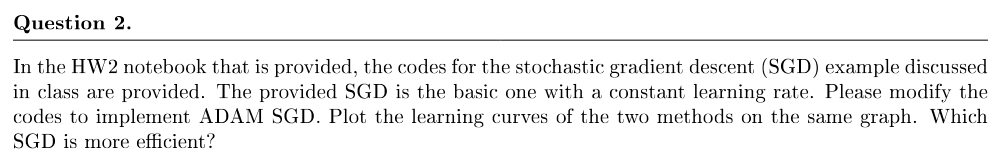

---

## 🚀 SGD vs ADAM Optimization on Feedforward Neural Network

This experiment compares the performance of two optimization algorithms — **Stochastic Gradient Descent (SGD)** and **ADAM** — for training a simple neural network from scratch on a binary classification task.

---

### 📦 Data Generation

We simulate a dataset with 2,000 observations using the following steps:

- Input features: 
  - $$ x_1 \sim \text{Uniform}(-1, 1) $$
  - $$ x_2 \sim \text{Uniform}(-1, 1) $$
  - $$ x_3 \sim \text{Uniform}(1, 10) $$
- Derived features:
  - $$ f_1 = x_1 $$
  - $$ f_2 = \frac{x_2}{x_3} $$
- Ground truth model:
  $$
  y^* = -2 + 1 \cdot f_1 + 10 \cdot f_2
  $$
- Binary label sampled from:
  $$
  P(y = 1) = \sigma(y^*) = \frac{e^{y^*}}{1 + e^{y^*}}
  $$

---

### 🧠 Neural Network Structure

The network consists of:

- **Input layer**: 3 features
- **Hidden layer**: 3 neurons, sigmoid activation
- **Output layer**: 1 neuron, sigmoid activation

Loss: Binary cross-entropy

---

### ⚙️ Optimizers

#### 1. **SGD (Stochastic Gradient Descent)**

Standard SGD with a fixed learning rate:
$$
\theta^{(k+1)} = \theta^{(k)} - \eta \cdot \nabla_\theta \mathcal{L}
$$
where:
- **θ**: model parameters
- **η**: learning rate
- **∇θ𝐿_batch**: gradient of the batch loss with respect to θ

#### 2. **ADAM (Adaptive Moment Estimation)**

Combines momentum and RMSProp with bias correction:
$$
\theta^{(k+1)} = \theta^{(k)} - \eta \cdot \frac{\hat{m}_k}{\sqrt{\hat{v}_k} + \varepsilon}
$$

where:
- **θ**: model parameters
- **η**: learning rate
- **m̂ₖ** : bias-corrected first moment estimate
- **v̂ₖ** : bias-corrected second moment estimate
- **ε**: small constant to prevent division by zero

In [35]:
import numpy as np

np.random.seed(202311)
x1 = np.random.random(2000)*2-1
x2 = np.random.random(2000)*2-1
x3 = np.random.random(2000)*9+1
f1 = x1
f2 = x2/x3
xmat = np.hstack(( np.repeat(1,2000).reshape((-1,1)), x1.reshape((-1,1)), x2.reshape((-1,1)), x3.reshape((-1,1)) ))
fmat = np.hstack(( np.repeat(1,2000).reshape((-1,1)), f1.reshape((-1,1)), f2.reshape((-1,1)) ))
betavec = np.array([-2, 1, 10]).reshape((-1 , 1))
ystarvec =  np.matmul(fmat, betavec)
sigmoidvec = np.exp(ystarvec)/((1+np.exp(ystarvec)))
yvec = np.random.binomial(size=ystarvec.shape, n=1, p= sigmoidvec)
#Wrong!###
#yvec = np.where(sigmoidvec>0.5,1,0)
#####
alldf = np.hstack((yvec , xmat[:,1:]))

X_train, X_valid = alldf[:1000,1:], alldf[1000:,1:]
y_train, y_valid = alldf[:1000,0], alldf[1000:,0]

class feedforwardnn:
    
    def __init__(self):
        self.dim = 3
        
    def loss(self,theta,x,y):
        w1mat = theta[7:].reshape((3,3))
        b1vec = theta[4:7].reshape((3,1))
        w2vec = theta[1:4].reshape((1,3))
        b2 = theta[0].reshape((-1,1))
        z1mat = np.matmul(w1mat,np.transpose(x)) + b1vec
        a1mat = 1/(1+np.exp(-z1mat))
        z2vec = np.matmul(w2vec,a1mat) + b2
        a2vec = 1/(1+np.exp(-z2vec))
        yhat = a2vec.reshape(-1,)
        lossval = np.mean(-y*np.log(yhat) - (1-y)*np.log(1-yhat))
        return(lossval)
        
    def grad(self,theta,x,y):
        w1mat = theta[7:].reshape((3,3))
        b1vec = theta[4:7].reshape((3,1))
        w2vec = theta[1:4].reshape((1,3))
        b2 = theta[0].reshape((-1,1))
        z1mat = np.matmul(w1mat,np.transpose(x)) + b1vec
        a1mat = 1/(1+np.exp(-z1mat))
        z2vec = np.matmul(w2vec,a1mat) + b2
        a2vec = 1/(1+np.exp(-z2vec))
        yhat = a2vec.reshape(-1,)
        gradloss = np.zeros(16)
        gradtemp1 = yhat-y
        gradtemp2 = (np.tile((yhat-y).reshape(1,-1),3).reshape(3,-1))*a1mat
        gradtemp3 = (np.tile((yhat-y).reshape(1,-1),3).reshape(3,-1))*theta[1:4].reshape(-1,1)*a1mat*(1-a1mat)
        gradloss[0] = np.mean(gradtemp1)
        gradloss[1:4] = np.mean(gradtemp2,axis=1)
        gradloss[4:7] = np.mean(gradtemp3,axis=1)
        gradloss[[7,10,13]] = np.mean(gradtemp3*np.tile(x[:,0].reshape(1,-1),3).reshape(3,-1),axis=1)
        gradloss[[8,11,14]] = np.mean(gradtemp3*np.tile(x[:,1].reshape(1,-1),3).reshape(3,-1),axis=1)
        gradloss[[9,12,15]] = np.mean(gradtemp3*np.tile(x[:,2].reshape(1,-1),3).reshape(3,-1),axis=1)
        return(gradloss)

### 🏋️‍♂️ SGD Training Loop

We train a feedforward neural network using **Stochastic Gradient Descent (SGD)** over 1000 epochs, tracking both training and validation loss to monitor learning progress.

---

#### 🔧 Initialization
- `epnum = 1000`: Number of training epochs  
- `bnum = 10`: Number of mini-batches per epoch  
- `lrate = 0.0025`: Learning rate  
- `thetavec`: Randomly initialized weight vector (16 parameters)  
- `thetamat`: Stores the parameter vector at each epoch  
- `losssgdffnnvec`: Stores training loss after each epoch  
- `val_loss_sgd`: Stores validation loss after each epoch  

---

#### 🔁 Training Procedure
For each epoch:
1. Split the training set into `bnum` mini-batches.
2. For each mini-batch:
   - Compute the gradient using `ffmodel.grad(...)`
   - Update parameters using the SGD update rule:  
     $$
     \theta \leftarrow \theta - \eta \cdot \nabla_\theta \mathcal{L}_{\text{batch}}
     $$
3. After all batches are processed:
   - Record updated parameters into `thetamat`
   - Compute and store both training and validation loss

---

This setup allows us to observe how the model fits the training data and generalizes to unseen data using **plain SGD** optimization.


In [37]:
epnum = 1000 #Number of epoch
bnum = 10 #Number of batches
lrate = 0.0025

ffmodel = feedforwardnn()
nrow = X_train.shape[0]
bnum = min(bnum,nrow)
bsize = nrow//bnum
np.random.seed(20240524)
thetavec = np.random.random(16)
thetamat = thetavec.reshape((1,-1))
losssgdffnnvec = [ffmodel.loss(thetavec, X_train, y_train)]
val_loss_sgd = [ffmodel.loss(thetavec, X_valid, y_valid)]

for epi in np.arange(epnum):
    for bi in np.arange(bnum):
        gradvec = ffmodel.grad(thetavec,
                               X_train[(bi*bsize):min(nrow,(bi+1)*bsize), :],
                               y_train[(bi*bsize):min(nrow,(bi+1)*bsize)])
        thetavec = thetavec - lrate * gradvec

    thetamat = np.vstack((thetamat, thetavec.reshape((1, -1))))
    losssgdffnnvec.append(ffmodel.loss(thetavec, X_train, y_train))
    val_loss_sgd.append(ffmodel.loss(thetavec, X_valid, y_valid))

### 🤖 ADAM Training Loop

We train the feedforward neural network using the **ADAM optimizer**, an adaptive learning algorithm that combines **momentum** and **variance scaling** for improved convergence.

---

#### 🔧 Initialization

- `epnum = 1000`: Total number of training epochs  
- `bnum = 10`: Number of mini-batches per epoch  
- `lrate = 0.0025`: Learning rate  
- `theta_adam`: Randomly initialized model parameters (vector of length 16)  
- `m`: First moment vector (mean of gradients), initialized to 0  
- `v`: Second moment vector (uncentered variance), initialized to 0  
- `beta1 = 0.9`, `beta2 = 0.999`: Exponential decay rates for the moment estimates  
- `eps = 1e-8`: Small constant to prevent division by zero  
- `loss_adam`: List to track training loss over epochs  

---

#### 🔁 Per-Epoch Training Procedure

For each epoch:

1. Split the training data into `bnum` mini-batches.
2. For each mini-batch:
   - Compute the gradient:  
     $$
     g_t = \nabla_\theta \mathcal{L}_{\text{batch}}(\theta)
     $$
   - Update biased moment estimates:  
     $$
     m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
     $$
     $$
     v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
     $$
   - Apply bias correction:  
     $$
     \hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad
     \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
     $$
   - Update parameters:  
     $$
     \theta \leftarrow \theta - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}
     $$
3. After completing all batches in the epoch, compute and store the training loss using the updated parameters.

---

This method dynamically adjusts learning rates per parameter and often outperforms basic SGD in terms of convergence speed and robustness.


In [38]:
# --- ADAM Training Loop ---
epnum = 1000
bnum = 10
lrate = 0.0025

ffmodel = feedforwardnn()
nrow = X_train.shape[0]
bnum = min(bnum, nrow)
bsize = nrow // bnum

np.random.seed(20240524)
theta_adam = np.random.random(16)
m = np.zeros_like(theta_adam)
v = np.zeros_like(theta_adam)
beta1, beta2 = 0.9, 0.999
eps = 1e-8

loss_adam = [ffmodel.loss(theta_adam, X_train, y_train)]
val_loss_adam = [ffmodel.loss(theta_adam, X_valid, y_valid)]  # <-- Add this line

for t in range(1, epnum + 1):
    for bi in range(bnum):
        grad = ffmodel.grad(
            theta_adam,
            X_train[(bi * bsize):min(nrow, (bi + 1) * bsize), :],
            y_train[(bi * bsize):min(nrow, (bi + 1) * bsize)]
        )
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        theta_adam -= lrate * m_hat / (np.sqrt(v_hat) + eps)
    
    loss_adam.append(ffmodel.loss(theta_adam, X_train, y_train))
    val_loss_adam.append(ffmodel.loss(theta_adam, X_valid, y_valid))  # <-- Add this line


### 📈 Plot Learning Curves: Training vs Validation

We visualize and compare the training dynamics of the feedforward neural network using **SGD** and **ADAM** optimizers.

For each method, we plot:

- **Training Loss**: Measures the model's performance on the training set.
- **Validation Loss**: Indicates how well the model generalizes to unseen data.

This side-by-side comparison highlights:
- The speed of convergence
- The stability of training
- The risk of overfitting (gap between train and validation curves)


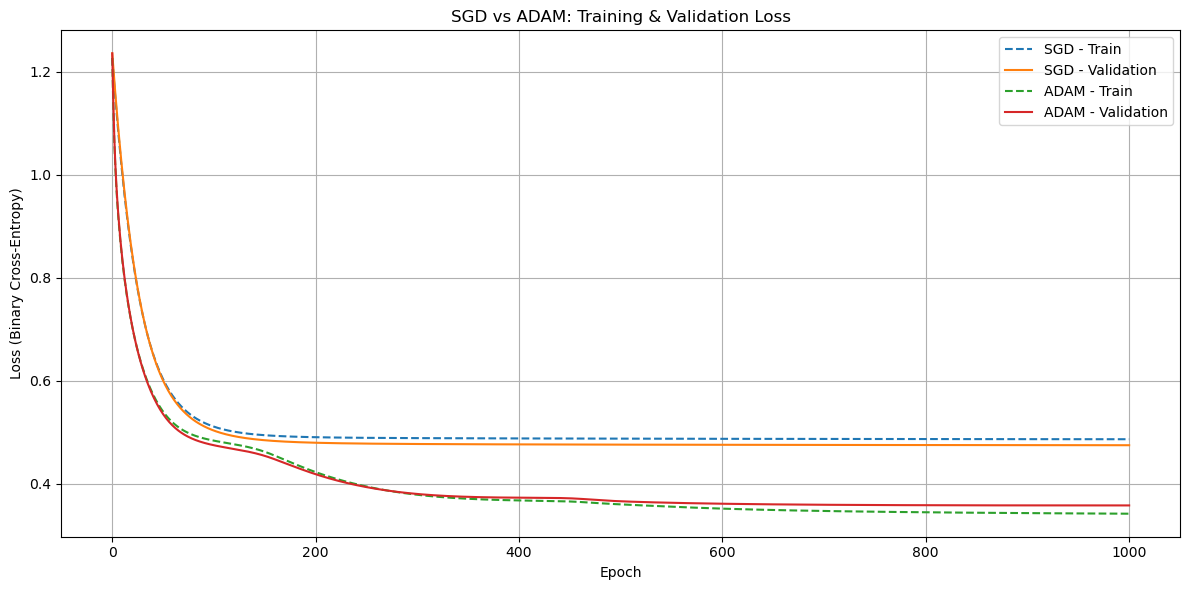

In [41]:
# --- Plot Training and Validation Loss for SGD and ADAM ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot for SGD
plt.plot(losssgdffnnvec, label='SGD - Train', linestyle='--', linewidth=1.5)
plt.plot(val_loss_sgd, label='SGD - Validation', linestyle='-', linewidth=1.5)

# Plot for ADAM
plt.plot(loss_adam, label='ADAM - Train', linestyle='--', linewidth=1.5)
plt.plot(val_loss_adam, label='ADAM - Validation', linestyle='-', linewidth=1.5)

plt.title("SGD vs ADAM: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Binary Cross-Entropy)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 🔍 Investigation: SGD vs ADAM – Training & Validation Loss

The plot above compares the **training and validation loss** curves for models trained using **SGD** (Stochastic Gradient Descent) and **ADAM** optimization.

#### 🧪 Observations:

- **Initial Convergence**: Both optimizers start with similar steep loss reduction, but ADAM descends more quickly and smoothly during early epochs.
- **Final Loss Values**:
  - **ADAM** achieves **lower training and validation loss** compared to SGD.
  - This suggests better overall fitting and generalization.
- **SGD Plateau**:
  - The SGD curves plateau early, indicating slower convergence and potential difficulty escaping shallow minima or adapting learning rate dynamics.
- **Overfitting**:
  - Both optimizers show **small gaps** between training and validation loss, with no severe overfitting observed.
  - ADAM exhibits better alignment between train and validation loss throughout the training, suggesting more stable generalization.

#### ✅ Conclusion:

ADAM clearly outperforms basic SGD in both **training speed** and **final performance**. Its adaptive moment estimation leads to more efficient and robust learning, especially valuable for models with many parameters or noisy gradients.


# Problem 3
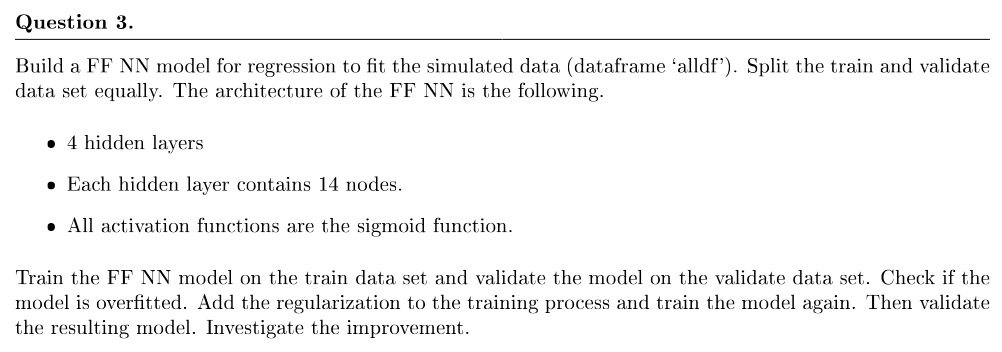

---

### 🧪 Data Generation and Simulation Description

This block of code simulates a synthetic regression dataset with context-dependent behavior.

#### 1. **Contextual Variable Simulation**
- Simulates 6000 samples of 3-dimensional contextual variables (`xc1`, `xc2`, `xc3`) from a uniform distribution between -1 and 1.
- Calculates a radial distance **r** for each sample:  
 $$ r = \sqrt{xc1^2 + xc2^2 + xc3^2} $$
- Assigns **context labels** based on the radius:
  - **Context 1**: r < 0.8  
  - **Context 2**: 0.8 ≤ r < 1.0  
  - **Context 3**: r ≥ 1.0

#### 2. **Regression Features**
- Generates 5 independent features (`x1` to `x5`) from a standard normal distribution.
- Adds a constant feature `x0 = 1` for bias handling, making 6 features in total.

#### 3. **Context-Specific Regression Coefficients**
- Generates a different coefficient vector `beta` for each context (`beta1`, `beta2`, `beta3`), each of shape (6,1).

#### 4. **Target Variable (y) Construction**
- Adds Gaussian noise `e ~ N(0, 0.1²)` to simulate realistic variability.
- For each context group, computes the response variable **y** using the equation:
$$ y = X \cdot \beta + \varepsilon $$
  - The appropriate `β` is selected based on the context of each sample.

#### 5. **Final Dataset Assembly**
- Combines:
  - ID and context features
  - Simulated features (`x1` to `x5`)
  - Target variable `y`
- Stores the combined dataset in a dataframe named `alldf`, ready for training a neural network.

This setup creates a realistic synthetic dataset that exhibits **non-stationary behavior** depending on the context radius.


In [3]:
# Do not make changes
import numpy as np
import pandas as pd
from numpy.random import MT19937

nval = 6000
#Simulate contextual variables of dim 3
rng = np.random.Generator(MT19937(seed=20250515))
random_ctxt = rng.uniform(low=-1, high=1, size=(nval, 3))
xctxtdf = pd.DataFrame(random_ctxt)
xctxtdf['id'] = np.arange(nval)
xctxtdf = xctxtdf.iloc[:,[3,0,1,2]]
xctxtdf.columns = ['id','xc1','xc2','xc3']
xctxtdf['context'] = 0
xctxtdf['r'] = np.sqrt(xctxtdf.xc1**2 + xctxtdf.xc2**2 + xctxtdf.xc3**2)
r1 = 0.8
r2 = 1
xctxtdf.context[xctxtdf.r < r1] = 1
xctxtdf.context[(xctxtdf.r >= r1)&(xctxtdf.r < r2)] = 2
xctxtdf.context[xctxtdf.r > r2] = 3
#Simulate regression variables of dim 5
random_features = rng.normal(size=[nval,5])
xdf = pd.DataFrame(random_features)
xdf.columns = ['x1','x2','x3','x4','x5']
xdf['x0'] = 1
#Simulate regression coef for each context
beta1 = rng.normal(size=[6,1])
beta2 = rng.normal(size=[6,1])
beta3 = rng.normal(size=[6,1])
#Simulate y
evec = rng.normal(0,0.1,size=[nval,1])
yvec = np.zeros((nval,1))
tempmat = np.array(xdf[xctxtdf.context==1])
yvec[xctxtdf.context == 1] = np.matmul(tempmat,beta1) + evec[xctxtdf.context == 1]
tempmat = np.array(xdf[xctxtdf.context==2])
yvec[xctxtdf.context == 2] = np.matmul(tempmat,beta2) + evec[xctxtdf.context == 2]
tempmat = np.array(xdf[xctxtdf.context==3])
yvec[xctxtdf.context == 3] = np.matmul(tempmat,beta3) + evec[xctxtdf.context == 3]
ydf = pd.DataFrame(yvec, columns=['y'])
#Put together the data frame
alldf = pd.concat([xctxtdf.iloc[:,0],ydf,xdf.iloc[:,:5],xctxtdf.iloc[:,1:4]],axis=1)

C:\Users\Panuruj\AppData\Local\Temp\ipykernel_14832\1967369043.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  xctxtdf.context[xctxtdf.r < r1] = 1
C:\Users\Panuruj\AppData\Local\Temp\ipykernel_14832\1967369043.py:18: SettingWithCopyWarn

### Preview of the Simulated Dataset (`alldf`)

The dataset `alldf` contains simulated observations used for contextual regression analysis. Below is a preview of the first few rows:

| id | y     | x1    | x2    | x3    | x4    | x5    | xc1   | xc2   | xc3   |
|----|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| …  | …     | …     | …     | …     | …     | …     | …     | …     | …     |

- **id**: Unique identifier for each observation.  
- **y**: Simulated target variable influenced by both context and regression variables.  
- **x1 to x5**: Input features (regression variables), drawn from a standard normal distribution.  
- **xc1 to xc3**: Contextual variables, drawn uniformly from \([-1, 1]\), used to determine the context region (sphere-based).  

The contextual classification (used internally) is based on the radius:  
- Region 1 if radius < 0.8  
- Region 2 if 0.8 ≤ radius < 1  
- Region 3 if radius > 1  


In [4]:
alldf.head()

id         y        x1        x2        x3        x4        x5       xc1  \
0   0 -0.645302  0.148021 -1.308003  1.260632 -0.279852  0.566952 -0.732179   
1   1 -0.279681 -0.887834  0.770436 -0.004214 -1.552206  0.258227  0.868481   
2   2  1.162492  0.576127 -0.454759 -0.108508 -0.074199  1.944397  0.048119   
3   3 -3.419321 -1.658789 -0.595741  0.216573  1.199203 -0.402713 -0.812957   
4   4 -2.085330  0.210830  0.822407  0.370260 -0.073860 -0.197890 -0.746164   

        xc2       xc3  
0 -0.290804  0.292533  
1  0.861913 -0.978909  
2  0.551515 -0.046190  
3 -0.774826 -0.895970  
4 -0.651308  0.143144

### Train-Validation Split

The dataset is split into features (`X`) and target (`y`) as follows:

- **Features (`X`)**: All columns except `id` and `y`, which include `x1` to `x5` and `xc1` to `xc3`.
- **Target (`y`)**: The column `y`, which represents the simulated response variable.

Then, the data is divided into training and validation sets using a **50/50 split** with a fixed `random_state=42` for reproducibility.

In [32]:
from sklearn.model_selection import train_test_split
# --- Train/Validation Split ---
X = alldf.drop(columns=['id', 'y'])
y = alldf['y']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

### Function: `build_model`

This function constructs a **Feedforward Neural Network (FFNN)** using TensorFlow/Keras with flexible options for regularization and dropout.

#### **Parameters**
- `reg_type`: *(str or None)*  
  Type of regularization to apply to each layer. Options:
  - `'l1'`: L1 regularization
  - `'l2'`: L2 regularization
  - `'l1_l2'`: both L1 and L2 regularization
  - `None`: no regularization

- `dropout_rate`: *(float, default = 0.0)*  
  Dropout rate to apply (between 0 and 1). Dropout is applied only to the specified hidden layers.

- `dropout_layers`: *(list of int or None)*  
  A list of indices (0-based) indicating which hidden layers should include dropout. If `None`, dropout is not applied.

- `learning_rate`: *(float, default = 0.001)*  
  Learning rate for the Adam optimizer.

#### **Architecture**
- **Input Layer**: Automatically adjusted to match the number of features.
- **Hidden Layers**: 4 layers, each with 14 nodes and sigmoid activation.
- **Dropout**: Optionally applied after specified hidden layers.
- **Output Layer**: Single neuron with linear activation (default for regression tasks).

#### **Returns**
A compiled `tf.keras.Sequential` model with mean squared error loss and mean absolute error as the evaluation metric.

#### **Example Usage**
```python
model = build_model(reg_type='l2', dropout_rate=0.2, dropout_layers=[2, 3], learning_rate=0.0005)


In [31]:
import tensorflow as tf

# --- Build FFNN Model with Flexible Dropout and Regularization ---
def build_model(reg_type=None, dropout_rate=0.0, dropout_layers=None, learning_rate=0.001):
    """
    Constructs a feedforward neural network model.

    Args:
        reg_type (str): Type of regularization: 'l1', 'l2', 'l1_l2', or None.
        dropout_rate (float): Dropout rate between 0 and 1.
        dropout_layers (list): Indices (0-based) of hidden layers to apply dropout.
        learning_rate (float): Learning rate for the Adam optimizer.

    Returns:
        tf.keras.Model: Compiled TensorFlow model.
    """
    model = tf.keras.Sequential()

    # Choose regularizer
    if reg_type == 'l1':
        regularizer = tf.keras.regularizers.l1(0.001)
    elif reg_type == 'l2':
        regularizer = tf.keras.regularizers.l2(0.001)
    elif reg_type == 'l1_l2':
        regularizer = tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)
    else:
        regularizer = None

    # Default to no dropout if not specified
    if dropout_layers is None:
        dropout_layers = []

    # Input layer
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    # Hidden layers
    for i in range(4):
        model.add(tf.keras.layers.Dense(
            14,
            activation='sigmoid',
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer
        ))
        if i in dropout_layers and dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))

    # Output layer
    model.add(tf.keras.layers.Dense(1))

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


### Feedforward Neural Network (FFNN) Regularization Experiments

To investigate the effect of various regularization techniques on overfitting and generalization, we train five different FFNN models using the same underlying architecture and optimizer setup. Each model varies only in the applied regularization method.

---

### 🔧 Shared Settings

All models are configured as follows:

- **Architecture**: 4 hidden layers, each with 14 units and sigmoid activation
- **Output Layer**: 1 linear neuron (regression task)
- **Loss Function**: Mean Squared Error (MSE)
- **Evaluation Metric**: Mean Absolute Error (MAE)
- **Optimizer**: Adam
- **Learning Rate**: 0.01
- **Batch Size**: 128
- **Epochs**: 10,000
- **Verbose**: 2 (prints one line per epoch)
- **Training/Validation Split**: 50% / 50% using `train_test_split`

---

### 📊 Regularization Configurations

#### **1. No Regularization (Baseline)**
- **Regularization**: None
- **Dropout**: None  
This serves as the baseline to observe the model's natural tendency to overfit.

In [11]:
# --- Train and Evaluate without Regularization ---
model_plain = build_model(reg_type=None,learning_rate=0.01)
history_plain = model_plain.fit(X_train, y_train,  epochs=10000, batch_size=128, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10000
24/24 - 1s - 44ms/step - loss: 6.9956 - mae: 2.0685 - val_loss: 6.2824 - val_mae: 1.9519
Epoch 2/10000
24/24 - 0s - 5ms/step - loss: 6.4403 - mae: 1.9792 - val_loss: 6.1207 - val_mae: 1.9442
Epoch 3/10000
24/24 - 0s - 5ms/step - loss: 6.2744 - mae: 1.9559 - val_loss: 5.7341 - val_mae: 1.8799
Epoch 4/10000
24/24 - 0s - 5ms/step - loss: 5.5810 - mae: 1.8359 - val_loss: 4.8605 - val_mae: 1.7137
Epoch 5/10000
24/24 - 0s - 5ms/step - loss: 4.9325 - mae: 1.7029 - val_loss: 4.5552 - val_mae: 1.6297
Epoch 6/10000
24/24 - 0s - 5ms/step - loss: 4.8099 - mae: 1.6761 - val_loss: 4.4952 - val_mae: 1.6279
Epoch 7/10000
24/24 - 0s - 5ms/step - loss: 4.7323 - mae: 1.6601 - val_loss: 4.4221 - val_mae: 1.6085
Epoch 8/10000
24/24 - 0s - 5ms/step - loss: 4.6621 - mae: 1.6467 - val_loss: 4.3518 - val_mae: 1.5993
Epoch 9/10000
24/24 - 0s - 4ms/step - loss: 4.6325 - mae: 1.6470 - val_loss: 4.3502 - val_mae: 1.6106
Epoch 10/10000
24/24 - 0s - 6ms/step - loss: 4.5807 - mae: 1.6373 - val_loss: 4.3

#### **2. L1 Regularization**
- **Regularization**: `tf.keras.regularizers.l1(0.001)`
- **Dropout**: None  
Encourages sparsity by driving some weights to zero, which can enhance interpretability and reduce overfitting in noisy contexts.

In [12]:
# --- Train and Evaluate with Regularization ---
model_reg_l1 = build_model(reg_type='l1',learning_rate = 0.01)
history_reg_l1 = model_reg_l1.fit(X_train, y_train, epochs=10000, batch_size=128, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10000
24/24 - 2s - 76ms/step - loss: 6.5868 - mae: 1.9825 - val_loss: 6.2700 - val_mae: 1.9515
Epoch 2/10000
24/24 - 0s - 5ms/step - loss: 6.4579 - mae: 1.9641 - val_loss: 5.9987 - val_mae: 1.9062
Epoch 3/10000
24/24 - 0s - 5ms/step - loss: 5.6712 - mae: 1.8371 - val_loss: 4.6350 - val_mae: 1.6144
Epoch 4/10000
24/24 - 0s - 5ms/step - loss: 4.8887 - mae: 1.6365 - val_loss: 4.5736 - val_mae: 1.5966
Epoch 5/10000
24/24 - 0s - 4ms/step - loss: 4.8155 - mae: 1.6392 - val_loss: 4.4971 - val_mae: 1.5823
Epoch 6/10000
24/24 - 0s - 5ms/step - loss: 4.7717 - mae: 1.6426 - val_loss: 4.4941 - val_mae: 1.6013
Epoch 7/10000
24/24 - 0s - 4ms/step - loss: 4.7630 - mae: 1.6419 - val_loss: 4.4544 - val_mae: 1.5786
Epoch 8/10000
24/24 - 0s - 5ms/step - loss: 4.7225 - mae: 1.6364 - val_loss: 4.4725 - val_mae: 1.5944
Epoch 9/10000
24/24 - 0s - 5ms/step - loss: 4.6931 - mae: 1.6357 - val_loss: 4.4495 - val_mae: 1.5920
Epoch 10/10000
24/24 - 0s - 5ms/step - loss: 4.6852 - mae: 1.6239 - val_loss: 4.4

#### **3. L2 Regularization**
- **Regularization**: `tf.keras.regularizers.l2(0.001)`
- **Dropout**: None  
Penalizes large weights, promoting smoother solutions and improving generalization without forcing weights to zero.

In [15]:
# --- Train and Evaluate with Regularization ---
model_reg_l2 = build_model(reg_type='l2',learning_rate = 0.01)
history_reg_l2 = model_reg_l2.fit(X_train, y_train, epochs=10000, batch_size=128, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10000
24/24 - 2s - 84ms/step - loss: 6.4863 - mae: 1.9796 - val_loss: 6.1661 - val_mae: 1.9379
Epoch 2/10000
24/24 - 0s - 5ms/step - loss: 6.2839 - mae: 1.9507 - val_loss: 5.5853 - val_mae: 1.8546
Epoch 3/10000
24/24 - 0s - 5ms/step - loss: 5.1609 - mae: 1.7535 - val_loss: 4.5526 - val_mae: 1.6021
Epoch 4/10000
24/24 - 0s - 5ms/step - loss: 4.7765 - mae: 1.6390 - val_loss: 4.4498 - val_mae: 1.6001
Epoch 5/10000
24/24 - 0s - 5ms/step - loss: 4.6847 - mae: 1.6416 - val_loss: 4.3922 - val_mae: 1.5890
Epoch 6/10000
24/24 - 0s - 5ms/step - loss: 4.6615 - mae: 1.6416 - val_loss: 4.3552 - val_mae: 1.5804
Epoch 7/10000
24/24 - 0s - 6ms/step - loss: 4.6917 - mae: 1.6555 - val_loss: 4.4759 - val_mae: 1.6299
Epoch 8/10000
24/24 - 0s - 5ms/step - loss: 4.6324 - mae: 1.6426 - val_loss: 4.3417 - val_mae: 1.5735
Epoch 9/10000
24/24 - 0s - 5ms/step - loss: 4.5862 - mae: 1.6267 - val_loss: 4.3230 - val_mae: 1.5890
Epoch 10/10000
24/24 - 0s - 6ms/step - loss: 4.5904 - mae: 1.6369 - val_loss: 4.4

#### **4. Dropout on All Hidden Layers**
- **Regularization**: None
- **Dropout**: 20% on all 4 hidden layers  
Applies random neuron deactivation during training to prevent co-adaptation and reduce overfitting. Inactive during validation/inference.

In [18]:
model_dropout = build_model(reg_type=None, dropout_rate=0.2,dropout_layers=[0, 1, 2, 3],learning_rate = 0.01)
history_dropout = model_dropout.fit(X_train, y_train, epochs=10000, batch_size=128, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10000
24/24 - 1s - 56ms/step - loss: 6.6671 - mae: 2.0126 - val_loss: 6.1497 - val_mae: 1.9487
Epoch 2/10000
24/24 - 0s - 5ms/step - loss: 6.4378 - mae: 1.9925 - val_loss: 6.0519 - val_mae: 1.9300
Epoch 3/10000
24/24 - 0s - 5ms/step - loss: 6.3157 - mae: 1.9645 - val_loss: 5.5117 - val_mae: 1.8460
Epoch 4/10000
24/24 - 0s - 5ms/step - loss: 5.5337 - mae: 1.8388 - val_loss: 4.5050 - val_mae: 1.6263
Epoch 5/10000
24/24 - 0s - 5ms/step - loss: 5.1318 - mae: 1.7523 - val_loss: 4.4567 - val_mae: 1.6033
Epoch 6/10000
24/24 - 0s - 6ms/step - loss: 4.9899 - mae: 1.7263 - val_loss: 4.4297 - val_mae: 1.6107
Epoch 7/10000
24/24 - 0s - 5ms/step - loss: 4.9200 - mae: 1.7073 - val_loss: 4.3935 - val_mae: 1.6089
Epoch 8/10000
24/24 - 0s - 6ms/step - loss: 5.0026 - mae: 1.7350 - val_loss: 4.3594 - val_mae: 1.5986
Epoch 9/10000
24/24 - 0s - 6ms/step - loss: 4.8798 - mae: 1.7048 - val_loss: 4.3559 - val_mae: 1.6015
Epoch 10/10000
24/24 - 0s - 4ms/step - loss: 4.8801 - mae: 1.7115 - val_loss: 4.3

#### **5. Dropout on Last Hidden Layer Only**
- **Regularization**: None
- **Dropout**: 20% on the last hidden layer (layer index 3)  
A targeted dropout strategy to regularize only the deepest layer, which typically captures high-level interactions.

In [20]:
model_dropout_2 = build_model(reg_type=None, dropout_rate=0.2,dropout_layers=[3],learning_rate = 0.01)
history_dropout_2 = model_dropout_2.fit(X_train, y_train, epochs=10000, batch_size=128, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10000
24/24 - 2s - 91ms/step - loss: 6.6573 - mae: 2.0167 - val_loss: 6.1884 - val_mae: 1.9612
Epoch 2/10000
24/24 - 0s - 5ms/step - loss: 6.4837 - mae: 1.9865 - val_loss: 5.9795 - val_mae: 1.9232
Epoch 3/10000
24/24 - 0s - 5ms/step - loss: 5.9654 - mae: 1.9121 - val_loss: 5.0283 - val_mae: 1.7539
Epoch 4/10000
24/24 - 0s - 5ms/step - loss: 5.0082 - mae: 1.7216 - val_loss: 4.4345 - val_mae: 1.6073
Epoch 5/10000
24/24 - 0s - 5ms/step - loss: 4.7980 - mae: 1.6809 - val_loss: 4.3947 - val_mae: 1.6190
Epoch 6/10000
24/24 - 0s - 5ms/step - loss: 4.7794 - mae: 1.6788 - val_loss: 4.3281 - val_mae: 1.5927
Epoch 7/10000
24/24 - 0s - 6ms/step - loss: 4.6243 - mae: 1.6468 - val_loss: 4.3220 - val_mae: 1.6028
Epoch 8/10000
24/24 - 0s - 6ms/step - loss: 4.6578 - mae: 1.6645 - val_loss: 4.2439 - val_mae: 1.5850
Epoch 9/10000
24/24 - 0s - 5ms/step - loss: 4.5979 - mae: 1.6437 - val_loss: 4.2274 - val_mae: 1.5950
Epoch 10/10000
24/24 - 0s - 5ms/step - loss: 4.5836 - mae: 1.6565 - val_loss: 4.2

### 📉 Training vs. Validation Loss Across Regularization Methods

This code block visualizes the loss curves for five different neural network configurations, each trained with a unique regularization method. It does the following:

- Defines a list of training histories and corresponding model labels.
- Creates a 3x2 grid of subplots to display individual loss trajectories.
- For each model:
  - Plots both training and validation loss over epochs.
  - Adds legends, axis labels, and subplot titles for clarity.
- Removes any unused subplot (e.g., the 6th panel) if fewer than six models are plotted.
- Applies tight layout formatting to prevent label overlap and ensure a clean presentation.

This enables a side-by-side visual comparison of how each regularization method impacts model training and generalization performance.


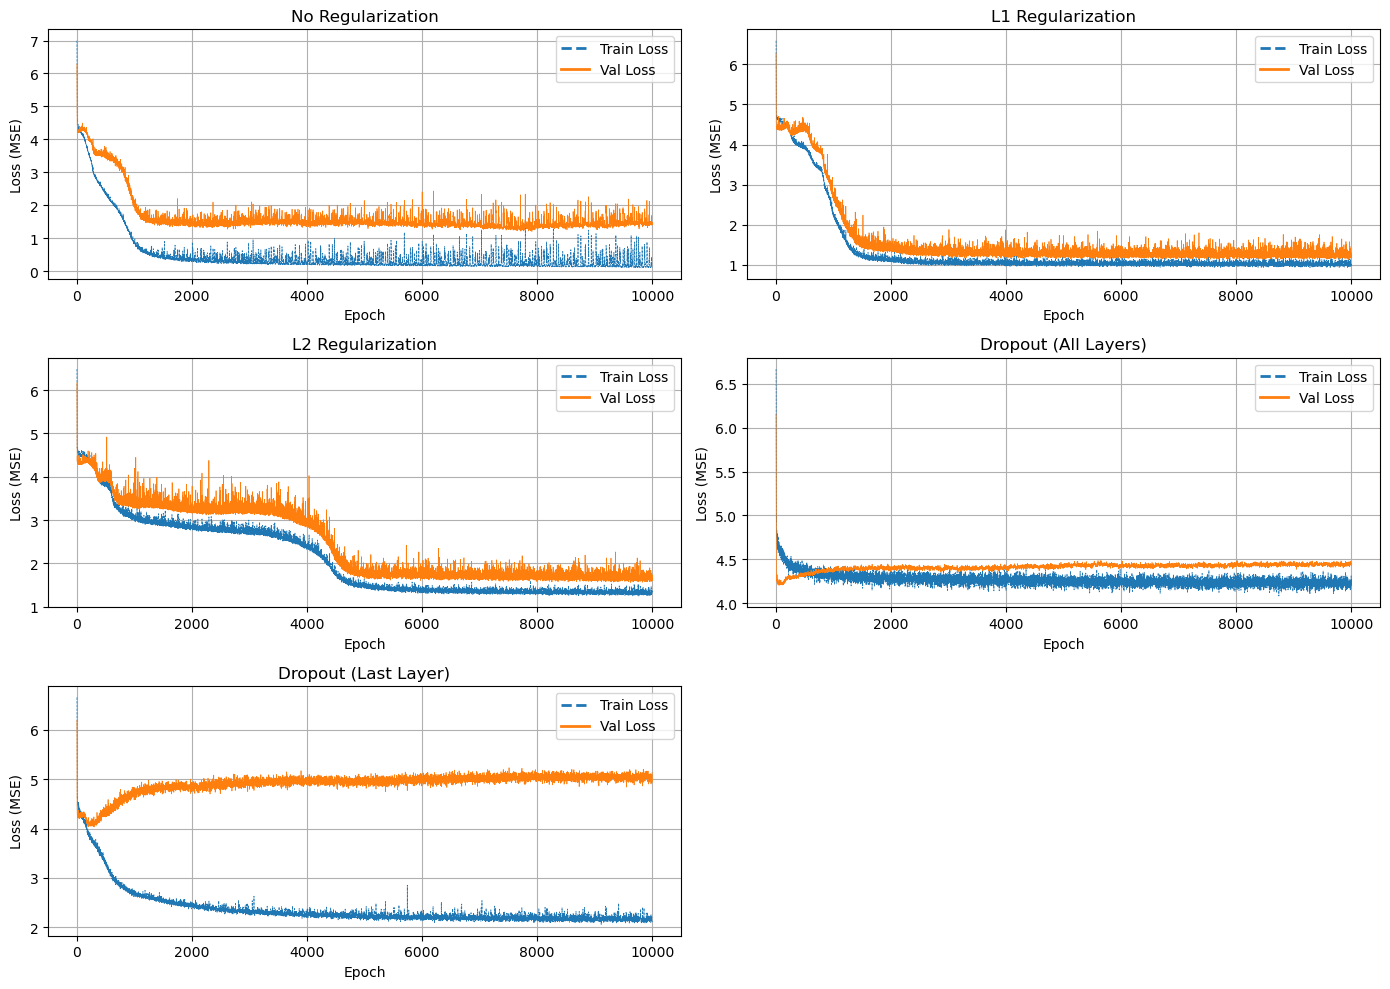

In [43]:
# Organize into list for iteration
histories = [
    ("No Regularization", history_plain),
    ("L1 Regularization", history_reg_l1),
    ("L2 Regularization", history_reg_l2),
    ("Dropout (All Layers)", history_dropout),
    ("Dropout (Last Layer)", history_dropout_2)
]

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Plotting ---
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, (title, hist) in enumerate(histories):
    ax = axes[i]
    
    # Thin plotted lines
    line_train, = ax.plot(hist.history['loss'], label='Train Loss', linestyle='--', linewidth=0.5)
    line_val, = ax.plot(hist.history['val_loss'], label='Val Loss', linestyle='-', linewidth=0.5)
    
    # Thick proxy lines for legend
    proxy_lines = [
        Line2D([0], [0], color=line_train.get_color(), linestyle='--', linewidth=2),
        Line2D([0], [0], color=line_val.get_color(), linestyle='-', linewidth=2)
    ]
    ax.legend(proxy_lines, ['Train Loss', 'Val Loss'])
    
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.grid(True)

# Remove empty subplot if odd number
if len(histories) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### 📊 Comparison of Regularization Techniques in FFNN Regression

The following figure compares training and validation loss curves across different regularization techniques applied to a Feedforward Neural Network trained on simulated contextual regression data.

#### 🔍 Observations

1. **No Regularization**  
   - **Training Loss** decreases steadily and reaches a low value.
   - **Validation Loss** plateaus early and shows considerable fluctuation, indicating **clear overfitting**.
   - The gap between training and validation loss widens over time.

2. **L1 Regularization**  
   - Both training and validation loss decrease consistently and remain close throughout training.
   - Slightly higher training loss than the unregularized model, but generalization is **significantly improved**.
   - This setup achieves **strong overfitting mitigation** with excellent fitness.

3. **L2 Regularization**  
   - Follows a similar trend to L1, but with a slightly larger train–val gap.
   - Training loss is well-controlled, and validation loss is more stable than the unregularized model.
   - **Moderate overfitting mitigation**, slightly worse than L1 but still effective.

4. **Dropout (All Hidden Layers)**  
   - Training loss is suppressed, but **convergence is shallow**.
   - Validation loss barely improves and remains high throughout training.
   - Indicates **underfitting**, likely due to excessive regularization when dropout is applied on every hidden layer.

5. **Dropout (Last Hidden Layer Only)**  
   - Training loss is low, but validation loss remains consistently high.
   - Displays **severe overfitting**, possibly because one layer of dropout is not sufficient to prevent memorization.
   - Worst generalization performance among all techniques.

#### ✅ Conclusion

- **Best Performer**: **L1 Regularization**, striking a strong balance between bias and variance.
- **Runner-up**: **L2 Regularization**, still effective but less aggressive than L1.
- **Dropout**: Requires more careful tuning; in this experiment, either too weak (last layer) or too strong (all layers).
- **No Regularization**: Demonstrates why regularization is essential, as it fails to generalize despite excellent training fit.
